In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from facenet_pytorch import MTCNN
import torch
import json
import os

# Load annotations
annotations_path = 'face_new_annotations.json'
with open(annotations_path, 'r') as f:
    annotations = json.load(f)


class FacesDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        self.mtcnn = MTCNN(keep_all=True, device='cpu')

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = list(self.annotations.keys())[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)

        # Use MTCNN to detect faces
        boxes, _ = self.mtcnn.detect(image)

        if boxes is None:
            return None

        box = boxes[0]
        face = image.crop(box)

        if self.transform:
            face = self.transform(face)

        label = self.annotations[img_name][0]['name']
        return face, label


# Define your transformations
transformations = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # Add normalization and any other required transformations here
])

# Initialize your dataset
faces_dataset = FacesDataset(
    'Photos', annotations, transform=transformations)

# Splitting the dataset
total_count = len(faces_dataset)
train_count = int(0.8 * total_count)
valid_count = int(0.1 * total_count)
test_count = total_count - (train_count + valid_count)

train_dataset, valid_dataset, test_dataset = random_split(
    faces_dataset, [train_count, valid_count, test_count])

In [4]:
def my_collate_fn(batch):
    # Filter out all the None samples
    batch = [data for data in batch if data is not None]
    return torch.utils.data.dataloader.default_collate(batch)


train_loader = DataLoader(train_dataset, batch_size=8,
                          shuffle=True, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8,
                          shuffle=False, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8,
                         shuffle=False, collate_fn=my_collate_fn)

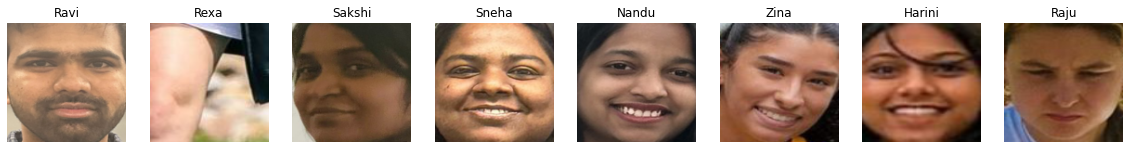

In [5]:
import matplotlib.pyplot as plt

# Function to convert a tensor to an image


def tensor_to_image(tensor):
    # Clone the tensor, move it to CPU and convert to a numpy array
    tensor = tensor.clone().detach().cpu().numpy()
    # Convert from (C, H, W) to (H, W, C) and undo normalization
    tensor = tensor.transpose(1, 2, 0)
    # Clip to ensure the image value is between 0 and 1, as it might have been affected by normalization
    tensor = tensor.clip(0, 1)
    return tensor


# Example: visualize the 1st sample of each minibatch of size 8
for i, (faces, labels) in enumerate(train_loader):
    if i == 0:  # Only process the first minibatch
        # Adjust the size as needed
        fig, ax = plt.subplots(1, 8, figsize=(20, 5))
        for j in range(8):
            img = tensor_to_image(faces[j])
            ax[j].imshow(img)
            ax[j].set_title(labels[j])
            ax[j].axis('off')
        plt.show()
        break  # Only show the first batch

In [6]:
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import os
import json
import math

# Load annotations
annotations_file_path = 'face_new_annotations.json'
with open(annotations_file_path, 'r') as file:
    annotations = json.load(file)

In [7]:
# Define the dataset class
class FaceDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
        # Assuming the original size is 224x224
        self.original_size = (224, 224)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = list(self.annotations.keys())[idx]
        img_annotations = self.annotations[img_name]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        orig_width, orig_height = image.size

        scale_x = self.original_size[0] / orig_width
        scale_y = self.original_size[1] / orig_height

        boxes = []
        names = []
        for face_data in img_annotations:
            box = [
                int(face_data['face_location']['top'] * scale_y),
                int(face_data['face_location']['right'] * scale_x),
                int(face_data['face_location']['bottom'] * scale_y),
                int(face_data['face_location']['left'] * scale_x)
            ]
            boxes.append(box)
            names.append(face_data['name'])

        boxes = torch.tensor(boxes) if boxes else torch.zeros((0, 4))

        if self.transform:
            image = self.transform(image)

        return image, boxes, names

In [8]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Create the dataset
img_dir = 'Photos'
face_dataset = FaceDataset(annotations, img_dir, transform=transform)

# Split the dataset
train_size = math.floor(0.8 * len(face_dataset))
val_size = math.floor(0.1 * len(face_dataset))
test_size = len(face_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    face_dataset, [train_size, val_size, test_size])

# Data loader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [9]:
# Adjust the dataloader to collate a batch properly

def collate_fn(batch):
    images, boxes_list, names_list = zip(*batch)

    # Pad the boxes and create a mask for valid boxes
    boxes_padded = pad_sequence(boxes_list, batch_first=True, padding_value=-1)
    masks = boxes_padded != -1  # Create a mask for valid bounding box values

    images = torch.stack(images)  # Stack images as they are of the same size
    return images, boxes_padded, names_list, masks


train_loader = DataLoader(train_dataset, batch_size=8,
                          shuffle=True, collate_fn=collate_fn)

# Visualization function adjustment to use the mask


def imshow_with_boxes(img, boxes, labels, masks, title):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
        torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    h, w, _ = img.shape
    for box, label, mask in zip(boxes, labels, masks):
        if mask[0]:  # Only plot if mask is true
            x1, y1, x2, y2 = box[3], box[0], box[1], box[2]
            width, height = x2 - x1, y2 - y1

            # Adjust for any bounding boxes if they are out of image boundaries
            x1 = max(0, x1)
            y1 = max(0, y1)
            width = min(w - x1, width)
            height = min(h - y1, height)

            # Draw the bounding box
            plt.gca().add_patch(Rectangle((x1, y1), width, height,
                                          edgecolor='red', facecolor='none', lw=2))
            # Position the text label
            label_x = x1 if x1 + width < w else w - width
            label_y = y1 if y1 + height < h else h - height

            # Draw the text
            plt.text(label_x, label_y, label, backgroundcolor='red', color='white',
                     fontsize=8, weight='bold', va='bottom', ha='left')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [10]:
# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# Instantiate model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Optimization loop for the first minibatch
first_batch = next(iter(train_loader))
images, annotations, names = first_batch[0], first_batch[1], first_batch[2]
labels = torch.randint(0, 2, (8,))
optimizer.zero_grad()
outputs = model(images)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

# Print the loss and visualize the first image with bounding box and name annotation
print(loss.item())

0.6802784204483032
